In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

# RGBD images
Open3D has a data structure for images. It supports various functions such as `read_image`, `write_image`, `filter_image` and `draw_geometries`. An Open3D Image can be directly converted to/from a numpy array.

An Open3D `RGBDImage` is composed of two images, `RGBDImage.depth` and `RGBDImage.color`. We require the two images to be registered into the same camera frame and have the same resolution. The following tutorials show how to read and use RGBD images from a number of well known RGBD datasets.

## Redwood dataset
In this section we show how to read and visualize an `RGBDImage` from the [Redwood dataset](http://redwood-data.org/) [Choi2015]_.

The Redwood format stored depth in a 16-bit single channel image. The integer value represents the depth measurement in millimeters. It is the default format for Open3D to parse depth images.

In [2]:
print("Read Redwood dataset")
color_raw = o3d.io.read_image("../../test_data/RGBD/color/00000.jpg")
depth_raw = o3d.io.read_image("../../test_data/RGBD/depth/00000.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)

Read Redwood dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


The default conversion function `create_rgbd_image_from_color_and_depth` creates an RGBDImage from a pair of color and depth image. The color image is converted into a grayscale image, stored in `float` ranged in [0, 1]. The depth image is stored in `float`, representing the depth value in meters.

The converted images can be rendered as numpy arrays.

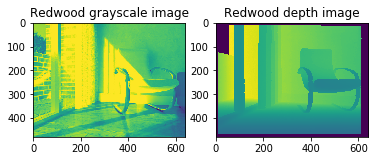

In [3]:
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

The RGBD image can be converted into a point cloud, given a set of camera parameters.

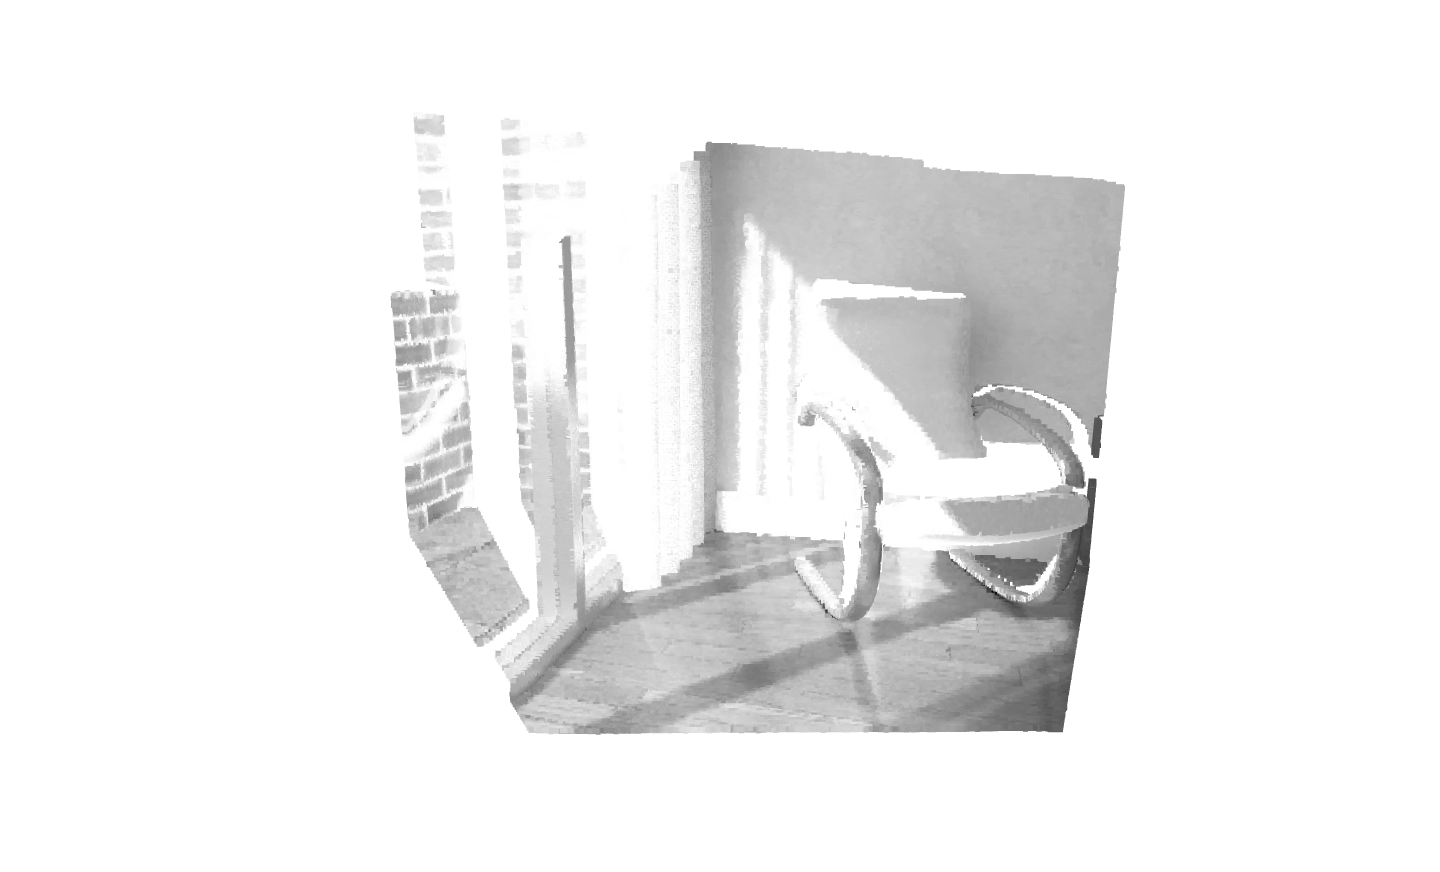

In [4]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.5)

Here we use `PinholeCameraIntrinsicParameters.PrimeSenseDefault` as default camera parameter. It has image resolution 640x480, focal length (fx, fy) = (525.0, 525.0), and optical center (cx, cy) = (319.5, 239.5). An identity matrix is used as the default extrinsic parameter. `pcd.transform` applies an up-down flip transformation on the point cloud for better visualization purpose. 

## SUN dataset
In this section we show how to read and visualize an RGBDImage of the [SUN dataset](http://rgbd.cs.princeton.edu/) [Song2015]_.

This tutorial is almost the same as the tutorial processing Redwood dataset above. The only difference is that we use the conversion function `create_rgbd_image_from_sun_format` to parse depth images in the SUN dataset.

In [5]:
print("Read SUN dataset")
color_raw = o3d.io.read_image(
    "../../test_data/RGBD/other_formats/SUN_color.jpg")
depth_raw = o3d.io.read_image(
    "../../test_data/RGBD/other_formats/SUN_depth.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_sun_format(color_raw, depth_raw)
print(rgbd_image)

Read SUN dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


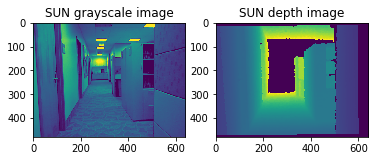

In [6]:
plt.subplot(1, 2, 1)
plt.title('SUN grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('SUN depth image')
plt.imshow(rgbd_image.depth)
plt.show()

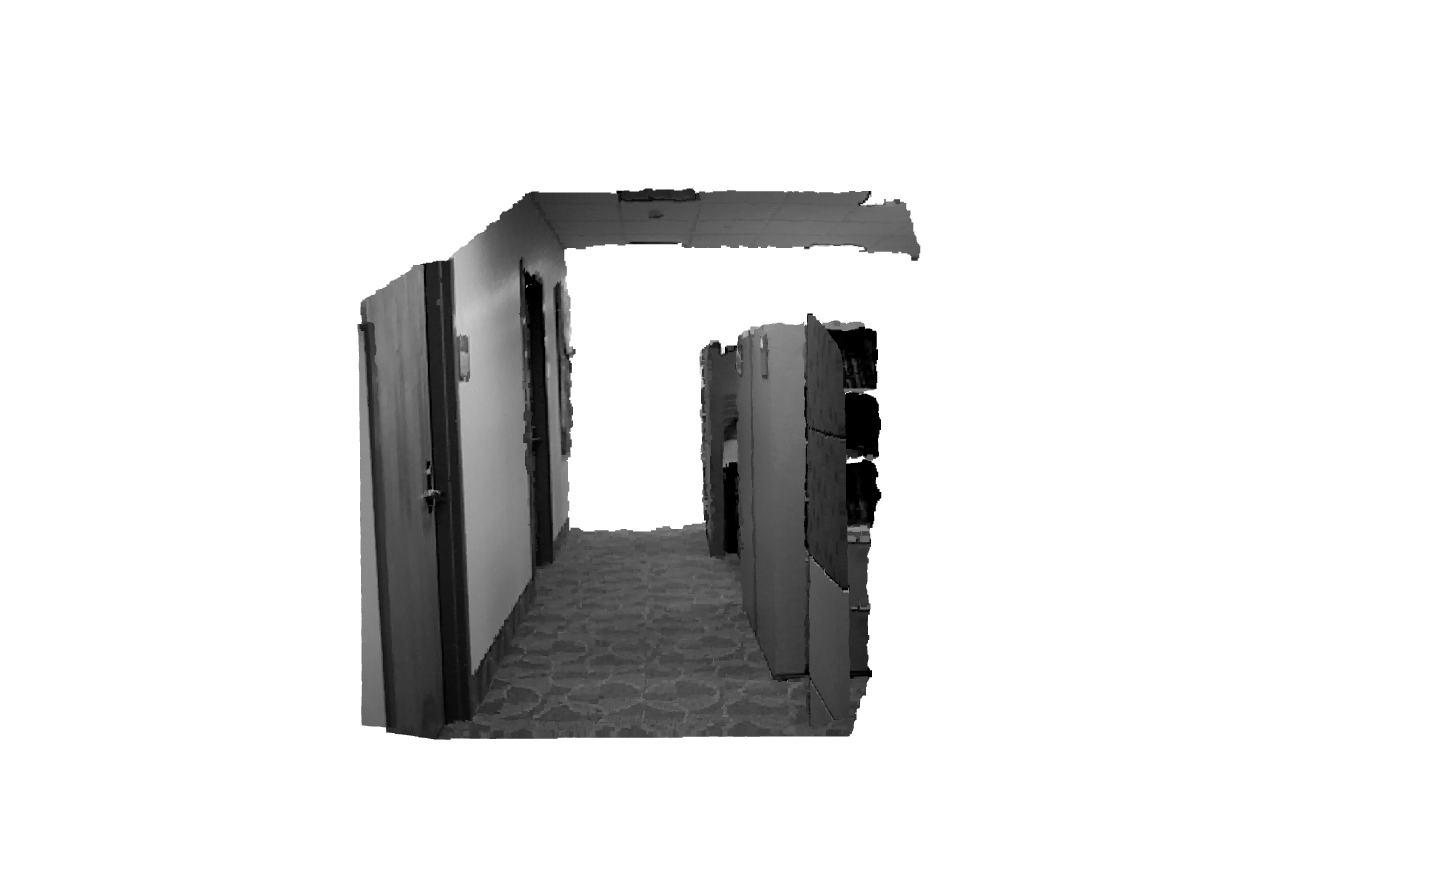

In [7]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.5)

## NYU dataset
This section shows how to read and visualize an `RGBDImage` from the [NYU dataset](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html) [Silberman2012]_. 

This tutorial is almost the same as the tutorial processing Redwood dataset above, with two differences. First, NYU images are not in standard `jpg` or `png` formats. Thus, we use `mpimg.imread` to read the color image as a numpy array and convert it to an Open3D `Image`. An additional helper function `read_nyu_pgm` is called to read depth images from the special big endian `pgm` format used in the NYU dataset. Second, we use a different conversion function `create_rgbd_image_from_nyu_format` to parse depth images in the SUN dataset.

In [8]:
import matplotlib.image as mpimg
import re


# This is special function used for reading NYU pgm format
# as it is written in big endian byte order.
def read_nyu_pgm(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    img = np.frombuffer(buffer,
                        dtype=byteorder + 'u2',
                        count=int(width) * int(height),
                        offset=len(header)).reshape((int(height), int(width)))
    img_out = img.astype('u2')
    return img_out


print("Read NYU dataset")
# Open3D does not support ppm/pgm file yet. Not using o3d.io.read_image here.
# MathplotImage having some ISSUE with NYU pgm file. Not using imread for pgm.
color_raw = mpimg.imread("../../test_data/RGBD/other_formats/NYU_color.ppm")
depth_raw = read_nyu_pgm("../../test_data/RGBD/other_formats/NYU_depth.pgm")
color = o3d.geometry.Image(color_raw)
depth = o3d.geometry.Image(depth_raw)
rgbd_image = o3d.geometry.RGBDImage.create_from_nyu_format(color, depth)
print(rgbd_image)

Read NYU dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


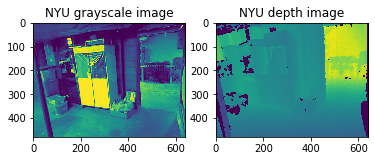

In [9]:
plt.subplot(1, 2, 1)
plt.title('NYU grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('NYU depth image')
plt.imshow(rgbd_image.depth)
plt.show()

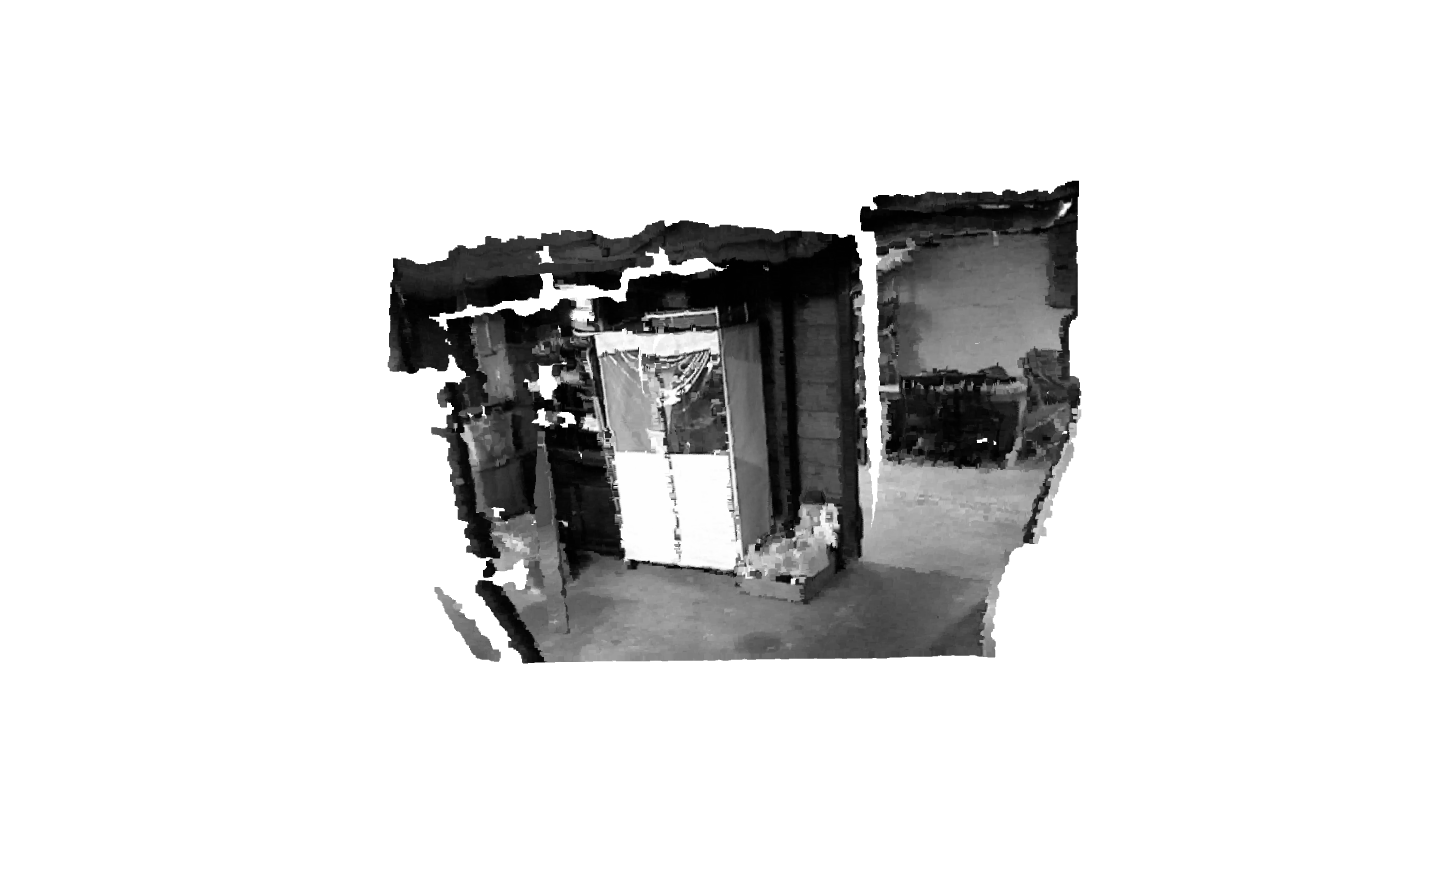

In [10]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.5)

## TUM dataset
This section shows how to read and visualize an RGBDImage from the [TUM dataset](https://vision.in.tum.de/data/datasets/rgbd-dataset) [Strum2012]_.

This tutorial is almost the same as the tutorial processing Redwood dataset above. The only difference is that we use the conversion function `create_rgbd_image_from_tum_format` to parse depth images in the TUM dataset.

In [11]:
print("Read TUM dataset")
color_raw = o3d.io.read_image(
    "../../test_data/RGBD/other_formats/TUM_color.png")
depth_raw = o3d.io.read_image(
    "../../test_data/RGBD/other_formats/TUM_depth.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_tum_format(color_raw, depth_raw)
print(rgbd_image)

Read TUM dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


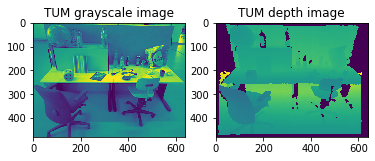

In [12]:
plt.subplot(1, 2, 1)
plt.title('TUM grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('TUM depth image')
plt.imshow(rgbd_image.depth)
plt.show()

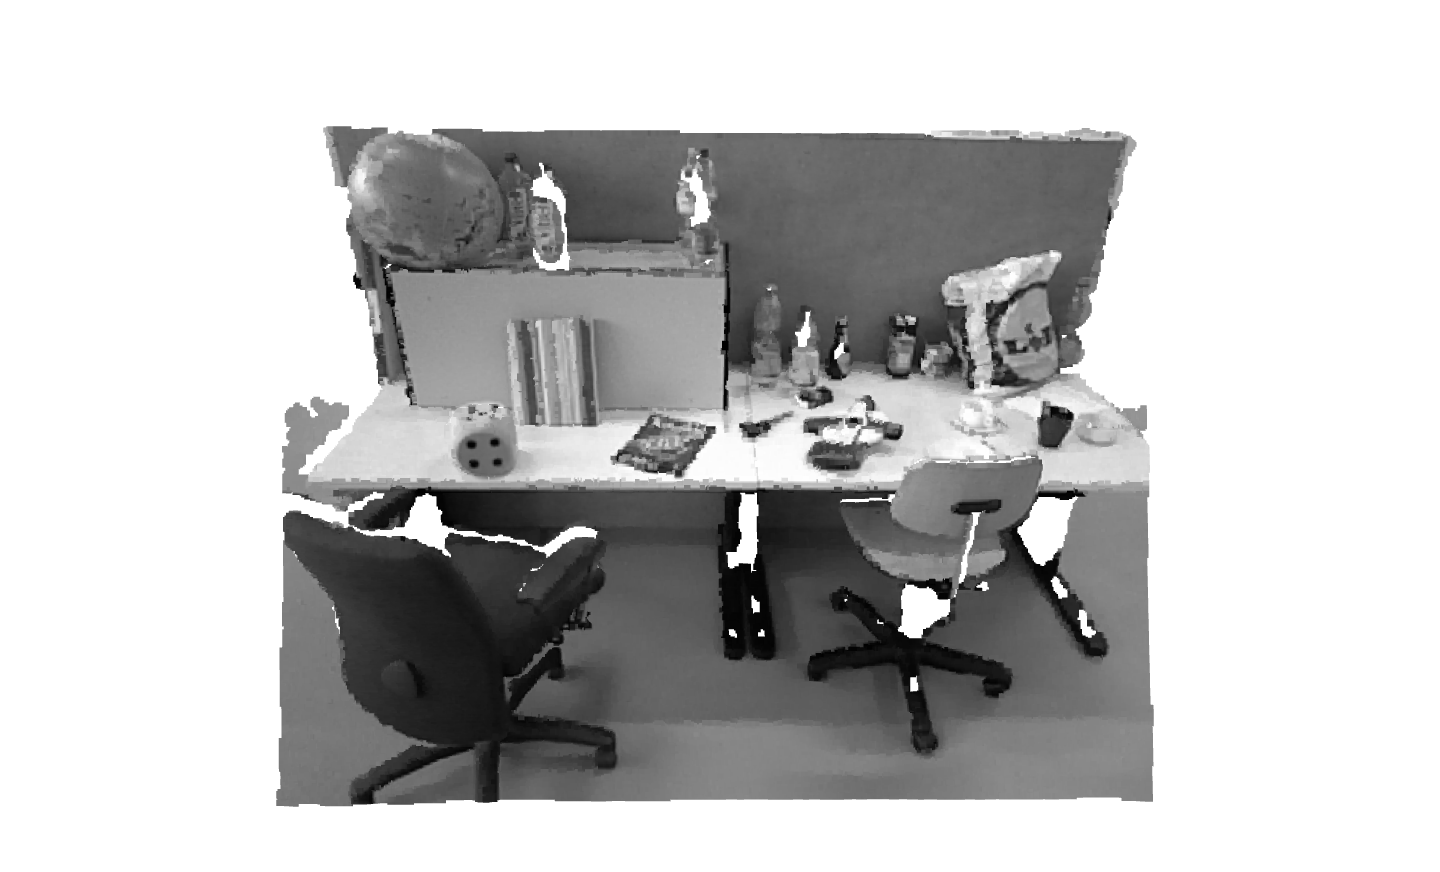

In [13]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.35)